# Progetto di esame di marco edoardo santimaria
Url del dataset: http://snap.stanford.edu/data/ca-GrQc.html

In [1]:
import pickle
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

In [2]:
collabGraph = nx.read_edgelist("CA-GrQc.txt", comments="#")

## Network metrics section

In [3]:
#number of edges and number of nodes

collabGraphNodeCount = collabGraph.number_of_nodes()
collabGraphEdgeCount = collabGraph.number_of_edges()

print(f"Number of nodes in network: {str(collabGraphNodeCount)} ")
print(f"Number of edges in network: {str(collabGraphEdgeCount)}")

Number of nodes in network: 5242 
Number of edges in network: 14496


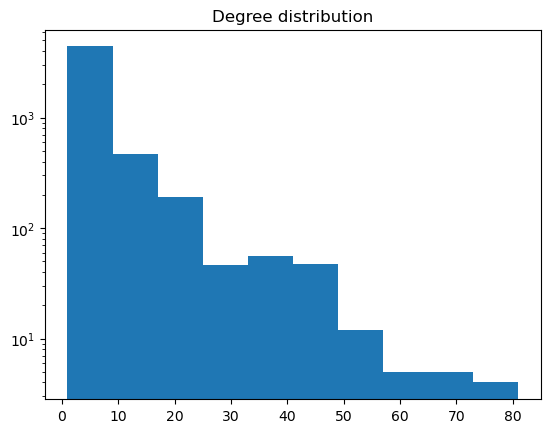

In [4]:
#degree distributions
collabGraphDegrees = [collabGraph.degree(node) for node in collabGraph.nodes()]


plt.hist(collabGraphDegrees, log=True)
plt.title("Degree distribution")
plt.show()


In [5]:
#connected components
collabGraphConnectedComponents = [c for c in nx.connected_components(collabGraph)]
collabGraphConnectedComponentsLen = [len(cc) for cc in collabGraphConnectedComponents]
collabGraphConnectedComponentsCount = nx.number_connected_components(collabGraph)
collabGraphBiggestConnectedComponent = collabGraph.subgraph(max(collabGraphConnectedComponents, key=len)).copy()

print(f"There are {str(collabGraphConnectedComponentsCount)} connected components in my graph.")
print(f"The biggest connected component has size: {max(collabGraphConnectedComponentsLen)} ")


There are 355 connected components in my graph.
The biggest connected component has size: 4158 


Text(0.5, 1.0, 'Size of each connected component')

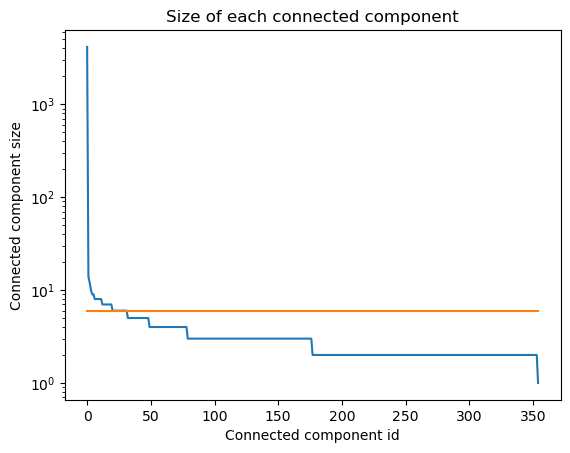

In [6]:
#plotting the size of connected components to identify a good cutoff value
#on x scale i have ache single connected component.
fig,ax = plt.subplots()
ax.plot([l for l in sorted(collabGraphConnectedComponentsLen , reverse=True)])
ax.plot([6 for _ in range(collabGraphConnectedComponentsCount)]) #immaginary cutoff to see at wich point i will cut the components
ax.set_yscale('log')
ax.set_xlabel("Connected component id")
ax.set_ylabel("Connected component size")
ax.set_title("Size of each connected component")

#by cutting for sizes of connected components greater than 6, i get around 25 cc

In [7]:
#connected components average degree but only for nodes with size greater than 6
collabGraphConnectedComponentsCuttedAtSix = [collabGraph.subgraph(c) for c in collabGraphConnectedComponents if len(c) > 6]

print("Average degree:\nSize\t<k>\n________________")
for c in collabGraphConnectedComponentsCuttedAtSix:
    print(f" {len(c)}\t{ round(sum( c.degree(nodes) for nodes in c) / c.number_of_nodes(),4) }" )

Average degree:
Size	<k>
________________
 4158	6.4589
 10	2.0
 12	3.3333
 7	3.4286
 7	2.0
 14	4.1429
 8	1.75
 9	2.6667
 7	4.0
 8	3.25
 8	6.0
 8	3.0
 7	2.2857
 8	4.5
 8	3.5
 9	4.2222
 7	3.1429
 7	2.8571
 7	2.5714
 7	6.0


In [8]:
#centrality of each node

#closeness centrality
collabCentralityCloseness = nx.closeness_centrality(collabGraphBiggestConnectedComponent)

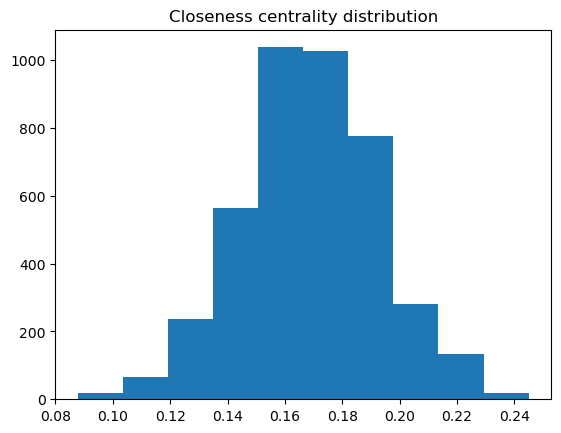

In [9]:
plt.hist(collabCentralityCloseness.values())
plt.title("Closeness centrality distribution")
plt.show()

In [10]:
#betweeness centrality
collabCentralityBetweeness = nx.betweenness_centrality(collabGraphBiggestConnectedComponent)

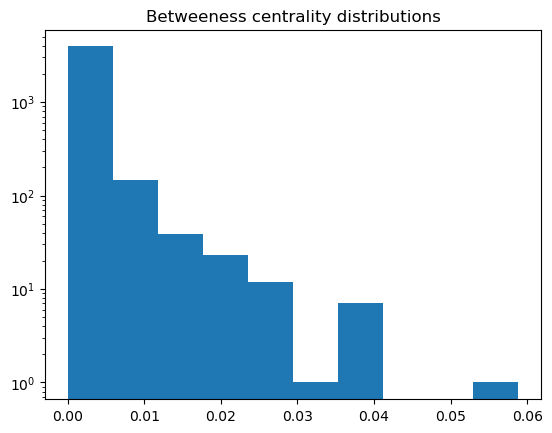

In [11]:
plt.hist(collabCentralityBetweeness.values(), log=True)
plt.title("Betweeness centrality distributions")
plt.show()

In [12]:
# longest shortest path for each node and graph diameter for biggest connected component

graphDiameter = nx.diameter( collabGraphBiggestConnectedComponent )
print(f"Diameter of the graph: {graphDiameter}")

Diameter of the graph: 17


In [13]:
#longest shortest path
#ma solo su cc piu grossa altrimenti mi vengono distanze infinite
# da questo posso vedere il range di distanza media che i nodi hanno
shortPath=[]
for node in collabGraphBiggestConnectedComponent.nodes():
    shortP = dict(nx.shortest_path_length(collabGraphBiggestConnectedComponent, source=node))
    maxV = 0
    for _,leng in shortP.items():
        if leng>maxV:
            maxV = leng
    shortPath.append([collabGraph.degree[node], maxV])

#sorting by high degree to low degree
shortPath.sort(key=lambda x:x[0], reverse=True)


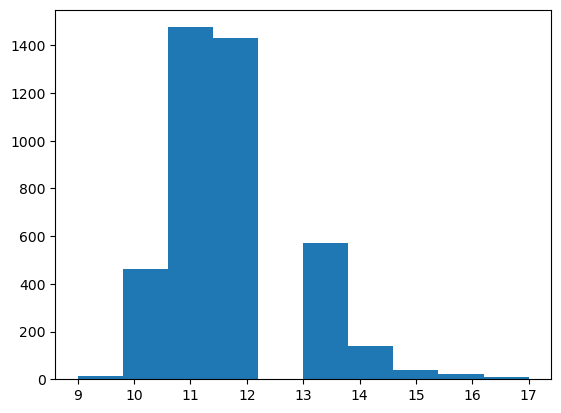

In [14]:
nodeSP = [sp for _,sp in shortPath] #mediamente tutti i nodi nel biggest connected component distano 11 steps

plt.hist(nodeSP)
plt.show()

In [15]:
#check the small world problem
print(float(graphDiameter) / np.log(collabGraphNodeCount))
#verified as diameter is in the same order of size
#checking also for average path length
print(nx.average_shortest_path_length( collabGraphBiggestConnectedComponent ) /  np.log(collabGraphNodeCount))
#verified also for average path length

1.9849474698821234
0.7063353857339955


In [16]:
#clustering coefficent of evry node (and network clustering coefficent)

collabGraphClusteringCoefficents = [nx.clustering(collabGraph, node) for node in collabGraph.nodes()]
print(f"Average clustering coefficent:  {sum(collabGraphClusteringCoefficents) / collabGraph.number_of_nodes()}")

Average clustering coefficent:  0.529635811052136


## Community detection

In [17]:
communitiesLouvain = nx.community.louvain_communities(collabGraphBiggestConnectedComponent)
print(f"Accoring to the louvain algorithm there are  {len(communitiesLouvain)} communities")

Accoring to the louvain algorithm there are  42 communities


In [18]:
communitiesGreedyModularity = nx.community.greedy_modularity_communities(collabGraphBiggestConnectedComponent)
print(f"Accoring to the greedy modularity maximization algorithm there are {len(communitiesGreedyModularity)} communities")

Accoring to the greedy modularity maximization algorithm there are 70 communities


In [19]:
#girvanNewmannCommunities = [community for community in nx.community.girvan_newman(collabGraphBiggestConnectedComponent)]
#print(f"According to the girvan newmann algorithm there are {len(girvanNewmannCommunities)}")

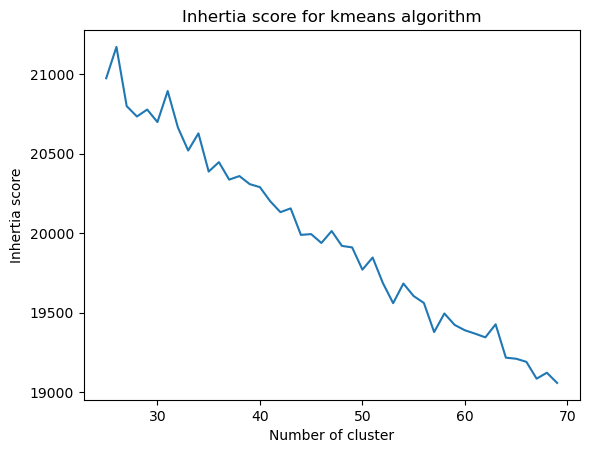

According to kmeans, there are 29 communities (silhuette score=0.23616899778694522)


In [22]:
#has the graph a hierarchical structure?
#testing with kmeans from k=390 to k=420
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings("ignore")

data = nx.to_numpy_array(collabGraph)
labels = []
sse = {}
silScore = []

for k in range(25, 70,1):
    kmeans = KMeans(n_clusters=k, max_iter=100).fit(data)
    labels.append(kmeans.labels_)
    silScore.append([k, silhouette_score(data, labels=labels[-1])])
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("Inhertia score")
plt.title("Inhertia score for kmeans algorithm")
plt.show() 

kMeansResult = max(silScore, key=lambda x: x[1])
print(f"According to kmeans, there are {kMeansResult[0]} communities (silhuette score={kMeansResult[1]})")


## Epidemic simulation

In [23]:
from simulation import *
import random

<Axes: title={'center': 'SIS model: node state proportions'}, xlabel='Simulation step', ylabel='Proportion of nodes'>

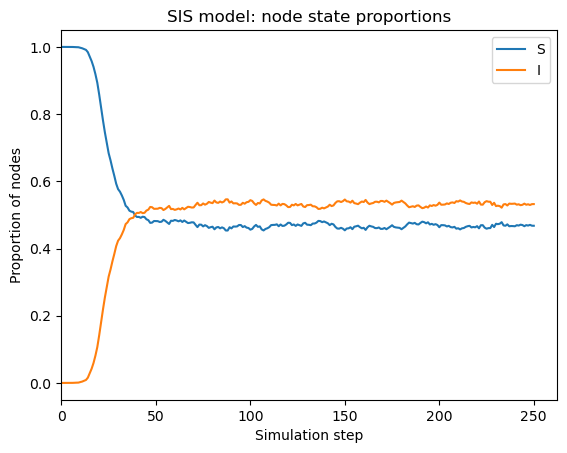

In [25]:
#PUNTO 1
def initial_state(G):
    state = {}
    for node in G.nodes:
        state[node] = 'S'
    
    patient_zero = random.choice(list(G.nodes))
    state[patient_zero] = 'I'
    return state

MU = 0.1
BETA = 0.1

def state_transition(G, current_state):
    next_state = {}
    for node in G.nodes:
        if current_state[node] == 'I':
            if random.random() < MU:
                next_state[node] = 'S'
        else: # current_state[node] == 'S'
            for neighbor in G.neighbors(node):
                if current_state[neighbor] == 'I':
                    if random.random() < BETA:
                        next_state[node] = 'I'

    return next_state


sim = Simulation(collabGraph, initial_state, state_transition, name='SIS model')
sim.run(250)
sim.plot()

In [ ]:
#PUNTO 2. simulare beta/mu e vedere che accade

In [26]:
#punto 3. togliere gli hub e poi stare a vedere che succede
node_degree_dict = [node for (node, val) in collabGraph.degree() if val > 16 ]
subGraphNoNodes = collabGraph.copy()
subGraphNoNodes.remove_nodes_from(node_degree_dict)

print(f"Remaining nodes: {len(subGraphNoNodes.nodes())} ")


Remaining nodes: 4877 


<Axes: title={'center': 'SIS model: node state proportions'}, xlabel='Simulation step', ylabel='Proportion of nodes'>

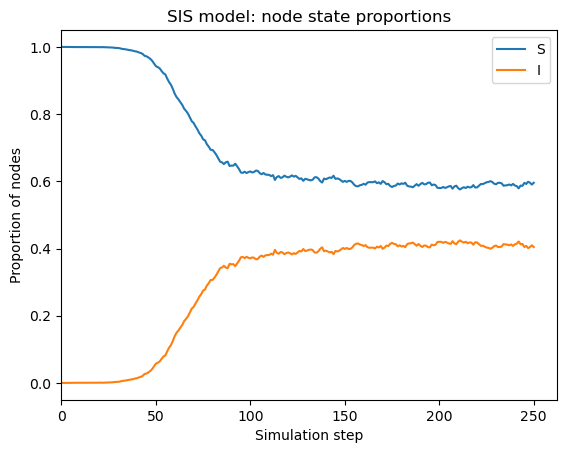

In [28]:
MU = 0.1
BETA = 0.1

sim = Simulation(subGraphNoNodes, initial_state, state_transition, name='SIS model')
sim.run(250)
sim.plot()
#rimuovendo gli hub si ottiene che il grafo non è piu connesso e quindi non vi è modo di avere spreading nella rete 
#sembra che se rimuovo i nodi con degree maggiore a 15 ottengo u grafo che non è piu connesso e non ho piu spreading.
#inoltre togliendo i nodi con una degree alta, ottengo che l'epiemic treshold viene superato molto di piu in la nel tempo 

In [29]:
#ESERCIZIO 4: k in singola community

MU = 0.1
BETA = 0.1



#PUNTO 1
def initial_state(G):
    state = {}
    for node in G.nodes:
        state[node] = 'S'
    
    patient_zero = random.choice(list(G.nodes))
    state[patient_zero] = 'I'
    return state


def initial_state_communities(G, communitiesAssignement, communitiesStartFromSingle, k=10):
    state = {}
   
    for node in G.nodes:
        state[node] = 'S'
    
    i=0
    if communitiesStartFromSingle:
        init_community = random.choice(communitiesAssignement)
        
        while i < k:
            patient_zero = random.choice(list(init_community))
            state[patient_zero] = 'I'
            i += 1
    else:
        while i < k:
            patient_zero = random.choice(list(communitiesAssignement[i]))
            state[patient_zero] = 'I'
            i += 1
    
    
    return state



def state_transition(G, current_state):
    next_state = {}
    for node in G.nodes:
        if current_state[node] == 'I':
            if random.random() < MU:
                next_state[node] = 'S'
        else: # current_state[node] == 'S'
            for neighbor in G.neighbors(node):
                if current_state[neighbor] == 'I':
                    if random.random() < BETA:
                        next_state[node] = 'I'

    return next_state

MU = 0.1
BETA = 0.1

""" sim = Simulation(collabGraph, initial_state, state_transition, name='SIS model',communities=False,  communitiesAssignement=communitiesLouvain, communitiesStartFromSingle=False)
sim.run(250)
sim.plot()
 """



" sim = Simulation(collabGraph, initial_state, state_transition, name='SIS model',communities=False,  communitiesAssignement=communitiesLouvain, communitiesStartFromSingle=False)\nsim.run(250)\nsim.plot()\n "

In [30]:
sim1 = Simulation(collabGraph, initial_state_communities, state_transition, name='SIS model-starting from a single community',communities=True,  communitiesAssignement=communitiesLouvainAssig[0], communitiesStartFromSingle=True)
sim1.run(250)
sim1.plot()



NameError: name 'communitiesLouvainAssig' is not defined

In [ ]:

sim2 = Simulation(collabGraph, initial_state_communities, state_transition, name='SIS model-starting from k communities',communities=True,  communitiesAssignement=communitiesLouvainAssig[0], communitiesStartFromSingle=False)
sim2.run(250)
sim2.plot()